In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#NER

In [ ]:
!pip install tf2crf
from tf2crf import CRF

In [4]:
df = pd.read_csv('/content/drive/MyDrive/NLP/4_Углубление в рекуррентные сети/data/ner.csv', 
                 encoding = "ISO-8859-1", error_bad_lines=False, index_col=0)

b'Skipping line 281837: expected 25 fields, saw 34\n'
/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df = df.drop_duplicates()
df

,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,they,respond,to,TO,lowercase,to,VBD,lowercase,responded,PRP,O,said,VBD,O,forc,NNS,lowercase,forces,lowercase,said,47959.0,lowercase,they,O
1048571,respond,to,the,DT,lowercase,the,TO,lowercase,to,VBD,O,they,PRP,O,said,VBD,lowercase,said,lowercase,they,47959.0,lowercase,responded,O
1048572,to,the,attack,NN,lowercase,attack,DT,lowercase,the,TO,O,respond,VBD,O,they,PRP,lowercase,they,lowercase,responded,47959.0,lowercase,to,O
1048573,the,attack,with,IN,lowercase,with,NN,lowercase,attack,DT,O,to,TO,O,respond,VBD,lowercase,responded,lowercase,to,47959.0,lowercase,the,O


In [6]:
df = df[['sentence_idx', 'word','tag']]
df

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O
...,...,...,...
1048570,47959.0,they,O
1048571,47959.0,responded,O
1048572,47959.0,to,O
1048573,47959.0,the,O


In [7]:
max_idx = int(df.sentence_idx.max())
max_idx

47959

In [8]:
df.loc[df['sentence_idx']==1, 'word']

0         Thousands
1                of
2     demonstrators
3              have
4           marched
5           through
6            London
7                to
8           protest
9               the
10              war
11               in
12             Iraq
13              and
14           demand
15              the
16       withdrawal
17               of
18          British
19           troops
20             from
21             that
22          country
23                .
Name: word, dtype: object

In [9]:
sequences = []
tags = []
for i in range(1, max_idx+1):
  sequences.append(df.loc[df['sentence_idx']==i, 'word'].values.tolist())
  tags.append(df.loc[df['sentence_idx']==i, 'tag'].values.tolist())

In [10]:
print(sequences[2])
print(tags[2])

['They', 'marched', 'from', 'the', 'Houses', 'of', 'Parliament', 'to', 'a', 'rally', 'in', 'Hyde', 'Park', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O']


In [11]:
sequences_ = [' '.join(sequence) for sequence in sequences]

In [12]:
sequences_[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [13]:
num_words = 5000
sent_len = 20
tokenizer = Tokenizer(num_words)

In [14]:
tokenizer.fit_on_texts(sequences_)

In [15]:
tokenizer.index_word

{1: 'the',
 2: 'in',
 3: 'of',
 4: 'to',
 5: 'a',
 6: 'and',
 7: "'s",
 8: 'for',
 9: 'has',
 10: 'on',
 11: 'is',
 12: 'that',
 13: 'have',
 14: 'u',
 15: 'with',
 16: 'said',
 17: 'was',
 18: 'at',
 19: 'says',
 20: 's',
 21: 'from',
 22: 'by',
 23: 'he',
 24: 'an',
 25: 'as',
 26: 'say',
 27: 'it',
 28: 'are',
 29: 'were',
 30: 'his',
 31: 'officials',
 32: 'president',
 33: 'will',
 34: 'government',
 35: 'mr',
 36: 'two',
 37: 'been',
 38: 'killed',
 39: 'people',
 40: 'not',
 41: 'after',
 42: 'its',
 43: 'but',
 44: 'be',
 45: 'they',
 46: 'more',
 47: 'also',
 48: 'year',
 49: 'new',
 50: 'united',
 51: 'military',
 52: 'last',
 53: 'who',
 54: 'country',
 55: 'police',
 56: 'than',
 57: 'one',
 58: 'minister',
 59: 'iraq',
 60: 'their',
 61: 'security',
 62: 'which',
 63: 'this',
 64: 'about',
 65: 'other',
 66: 'states',
 67: 'had',
 68: 'least',
 69: 'state',
 70: 'three',
 71: 'tuesday',
 72: 'group',
 73: 'iran',
 74: 'forces',
 75: 'week',
 76: 'world',
 77: 'since',
 78:

In [16]:
X = tokenizer.texts_to_sequences(sequences_)

In [17]:
X = pad_sequences(X, sent_len)

In [18]:
X.shape

(47959, 20)

In [19]:
tags = [' '.join(tag) for tag in tags]

In [20]:
tag_tokenizer = Tokenizer(df.tag.nunique(), filters=' ')

In [21]:
tag_tokenizer.fit_on_texts(tags)

In [22]:
tag_tokenizer.index_word

{1: 'o',
 2: 'b-geo',
 3: 'b-tim',
 4: 'b-org',
 5: 'i-per',
 6: 'b-per',
 7: 'i-org',
 8: 'b-gpe',
 9: 'i-geo',
 10: 'i-tim',
 11: 'b-art',
 12: 'b-eve',
 13: 'i-eve',
 14: 'i-art',
 15: 'b-nat',
 16: 'i-gpe',
 17: 'i-nat'}

In [23]:
Y = tag_tokenizer.texts_to_sequences(tags)
Y = pad_sequences(Y, sent_len, value=1)

In [24]:
Y.shape

(47959, 20)

In [25]:
Y = to_categorical(Y, df.tag.nunique()+1)

In [26]:
Y.shape

(47959, 20, 18)

In [27]:
Y = Y[:, :, 1:]
Y.shape

(47959, 20, 17)

In [28]:
emb_size = 200

input = Input(shape=(None,))
x = Embedding(num_words, emb_size)(input)
x = Bidirectional(LSTM(emb_size, return_sequences=True))(x)
x = LSTM(emb_size * 2, return_sequences=True)(x)
x = Dense(df.tag.nunique(), activation='softmax')(x)
#output = CRF()(x)

model = Model(input, x)

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# fit model
history = model.fit(X, Y, validation_split=0.2,
          epochs = 10, verbose = 1)

Epoch 1/10
1199/1199 [==============================] - 33s 21ms/step - loss: 0.4369 - accuracy: 0.9143 - val_loss: 0.3720 - val_accuracy: 0.8955
Epoch 2/10
1199/1199 [==============================] - 24s 20ms/step - loss: 0.2316 - accuracy: 0.9328 - val_loss: 0.3349 - val_accuracy: 0.9005
Epoch 3/10
1199/1199 [==============================] - 24s 20ms/step - loss: 0.2006 - accuracy: 0.9374 - val_loss: 0.3221 - val_accuracy: 0.9025
Epoch 4/10
1199/1199 [==============================] - 24s 20ms/step - loss: 0.1799 - accuracy: 0.9409 - val_loss: 0.3235 - val_accuracy: 0.9031
Epoch 5/10
1199/1199 [==============================] - 24s 20ms/step - loss: 0.1591 - accuracy: 0.9462 - val_loss: 0.3345 - val_accuracy: 0.9027
Epoch 6/10
1199/1199 [==============================] - 24s 20ms/step - loss: 0.1412 - accuracy: 0.9516 - val_loss: 0.3540 - val_accuracy: 0.8995
Epoch 7/10
1199/1199 [==============================] - 25s 21ms/step - loss: 0.1213 - accuracy: 0.9578 - val_loss: 0.3809 -

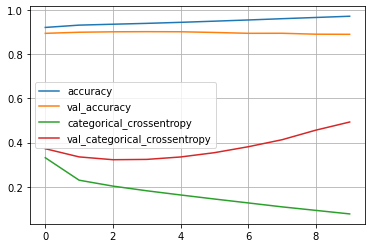

In [31]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='categorical_crossentropy')
plt.plot(history.history['val_loss'], label='val_categorical_crossentropy')
plt.legend()
plt.grid()
plt.show()